### Data setup

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

It's a 5
With shape (784,)


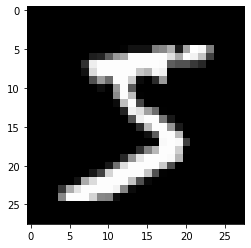

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
print("It's a {}".format(y_train[0]))
print("With shape {}".format(x_train[0].shape))

### Convert data to torch.tensor from numpy array

In [4]:
import torch

x_train, y_train, x_valid, y_valid = x_train.copy(), y_train.copy(), x_valid.copy(), y_valid.copy()
n, c = x_train.shape
print(x_train.dtype)
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
print(x_train.dtype)
print(x_train.max())

float32
torch.float32
tensor(0.9961)


In [5]:
print(x_train.shape)

torch.Size([50000, 784])


## Neural net from scratch (no torch.nn)

In [6]:
#initialize weights
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

print(weights.shape)
print(weights)
print(bias)

torch.Size([784, 10])
tensor([[ 0.0129,  0.0627,  0.0073,  ..., -0.0122,  0.0396, -0.0009],
        [-0.0273,  0.0390,  0.0159,  ...,  0.0143, -0.0256, -0.0212],
        [ 0.0248, -0.0055, -0.0493,  ..., -0.0362, -0.0229, -0.0353],
        ...,
        [-0.0357, -0.0275, -0.0035,  ..., -0.0473,  0.0145, -0.0405],
        [-0.0006,  0.0444,  0.0143,  ..., -0.0042,  0.0510,  0.0058],
        [-0.0229,  0.0007,  0.0429,  ..., -0.0130, -0.0080, -0.0374]],
       requires_grad=True)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [7]:
#activation function

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

#### Preds

In [8]:
batch_size = 64

xb = x_train[:batch_size]
preds = model(xb) #predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-1.8917, -2.3840, -2.1683, -2.5407, -2.1563, -2.2441, -2.0548, -2.5614,
        -2.5400, -2.8498], grad_fn=<SelectBackward>) torch.Size([64, 10])


#### Loss function

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [10]:
yb = y_train[:batch_size]
print(loss_func(preds, yb))

tensor(2.3834, grad_fn=<NegBackward>)


#### Accuracy

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

print(accuracy(preds,yb))

tensor(0.1250)


#### Training loop

In [12]:
from IPython.core.debugger import set_trace

learning_rate = 5e-1
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // batch_size + 1):
        #set_trace()
        start_i = i * batch_size
        end_i = start_i + batch_size
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * learning_rate
            bias -= bias.grad * learning_rate
            weights.grad.zero_()
            bias.grad.zero_()

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0802, grad_fn=<NegBackward>) tensor(1.)


#### Using torch.nn functional 

In [14]:
#loss function with torch.nn.functional as F
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0802, grad_fn=<NllLossBackward>) tensor(1.)


#### NN module

In [16]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super(Mnist_Logistic, self).__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias
    
model = Mnist_Logistic()

In [17]:
print(loss_func(model(xb), yb))

tensor(2.3196, grad_fn=<NllLossBackward>)


#### Training loop

In [18]:
# with torch.no_grad():
#     for p in model.parameters(): p -= p.grad * learning_rate
#     model.zero_grad()

In [19]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * learning_rate
                model.zero_grad()

fit()

In [20]:
print(loss_func(model(xb), yb))

tensor(0.0834, grad_fn=<NllLossBackward>)


#### Refactor using torch.nn.Linear

In [21]:
class MnistLogistic(nn.Module):
    def __init__(self):
        super(MnistLogistic, self).__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)
    
model = MnistLogistic()
print(loss_func(model(xb), yb))

tensor(2.3923, grad_fn=<NllLossBackward>)


In [22]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward>)


#### Refactor using optim

In [25]:
from torch import optim
cuda = torch.device('cuda')

def get_model():
    model = MnistLogistic()
    model.cuda()
    return model, optim.SGD(model.parameters(), lr=learning_rate)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))        

SyntaxError: cannot assign to function call (<ipython-input-25-aa5bd08033fa>, line 16)

#### Refactor using Dataset

In [ ]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
# xb,yb = train_ds[i*batch_size : i*batch_size+batch_size]

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1) // batch_size+1):
        xb, yb = train_ds[i*batch_size:i*batch_size+batch_size]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb),yb).detach().numpy(), accuracy(model(xb), yb).numpy())

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=batch_size)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb),yb).detach().numpy(), accuracy(model(xb), yb).numpy())

In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(train_ds, batch_size=batch_size*2, shuffle=False)

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
print("Training loss: {}  Training accuracy: {}".format(loss_func(model(xb),yb).detach().numpy(), accuracy(model(xb), yb).numpy()))
print("Validation loss: {}".format(valid_loss / len(valid_ds)))

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
import numpy as np
cuda = torch.device('cuda')

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb.cuda(), yb.cuda(), opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

### CNN version of a model

In [ ]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) #pytorch version of numpy (view) and reshaping
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 1e-1

In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

### Let's use GPU

In [ ]:
print(torch.cuda.is_available())